In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import numpy as np
import torch
import urllib
from src.utils import *
from src.models.baseline import Baseline
from torch import nn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from datasets import Dataset, concatenate_datasets
from tqdm import tqdm
from transformers import BertLayer, AutoModelForSequenceClassification, DataCollatorWithPadding, AutoTokenizer, AutoConfig, TrainingArguments, Trainer, BertConfig, BertModel, BertPreTrainedModel, RobertaConfig, RobertaModel

c:\Users\marco\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)
torch.cuda.is_available()

True

In [2]:
url = "https://drive.google.com/uc?export=download&id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2"
dataset_name = "MELD_train_efr.json"

df_manager = DataframeManager(url, dataset_name)

df = df_manager.produce_df()
df

Current work directory: d:\shared\unibo\year2\NLP\assignments\project


,episode,emotions,utterances,triggers,emotions_id
0,utterance_0,"[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0, 0, 0, 1, 0]","[1, 1, 1, 1, 0]"
1,utterance_1,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 1, 0]","[1, 1, 1, 1, 0, 1, 1]"
2,utterance_2,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 5]"
3,utterance_3,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 5, 1, 0]"
4,utterance_4,"[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0, 0, 1, 0]","[0, 6, 0, 5]"
...,...,...,...,...,...
3995,utterance_3995,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 2, 1, 1, 0, 4, 1, 4, 0, 1, 1, 4]"
3996,utterance_3996,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 2, 1, 1, 0, 4, 1, 4, 0, 1, 1, 4, 4, 1]"
3997,utterance_3997,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 2, 1, 1, 0, 4, 1, 4, 0, 1, 1, 4, 4, 1, 1]"
3998,utterance_3998,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 2, 1, 1, 0, 4, 1, 4, 0, 1, 1, 4, 4, 1, 1, 0]"


In [5]:
train_df, val_df, test_df = df_manager.split_df(RANDOM_SEED)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3200, 5)
(400, 5)
(400, 5)


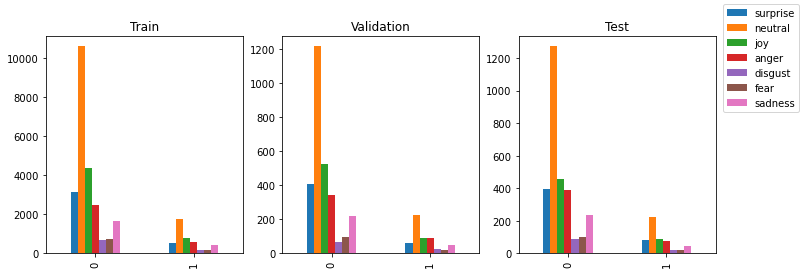

In [6]:
df_manager.plot_emotion_distribution(train_df, val_df, test_df)

In [10]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [9]:
train_dataset[3070]

{'episode': 'utterance_3176',
 'emotions': ['fear',
  'neutral',
  'neutral',
  'neutral',
  'anger',
  'neutral',
  'sadness'],
 'utterances': ["I'm so sorry. Please, stop freaking out.",
  "I'm not freaking out.",
  'Why would I be freaking out?',
  'A woman named Heldi called and said we were getting married, but that happens everyday.',
  'Honey, we were at this beautiful place, and I-I-I just put our names down for fun!',
  "I mean, what's the harm in that?",
  'Right here!'],
 'triggers': [0, 0, 0, 1, 1, 1, 0],
 'emotions_id': [6, 5, 5, 5, 2, 5, 1],
 '__index_level_0__': 3176}

In [10]:
model_card = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir = "./model_dir/"+model_card+"/"
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
train_data_tokenised, val_data_set, test_data_set = get_datasets(train_dataset, val_dataset, test_dataset, tokenizer)
print(train_data_tokenised[1])

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

{'episode': 'utterance_3491', 'emotions': ['surprise', 'fear', 'surprise', 'sadness'], 'utterances': ['You-you\x85you had sex with Ursula?!', 'Uh, a little bit. She-she-she walked in and I thought she was you and I kissed her and', "You didn't notice she was wearing different clothes?!", 'Well I was just so excited to see you.'], 'triggers': tensor([0, 0, 1, 0]), 'emotions_id': tensor([4, 6, 4, 1]), '__index_level_0__': tensor(3491), 'input_ids': tensor([[  101,  2017,  1011,  2017, 29337,  2018,  3348,  2007, 20449,  1029,
           999,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  101,  7910,  1010,  1037,  2210,  2978,  1012,  2016,  1011,  2016,
          1011,  2016,  2939,  1999,  1998,  1045,  2245,  2016,  2001,  2017,
          1998,  1045,  4782,  2014,  1998,   102],
        [  101,  2017,  2134,  1005,  1056,  5060,  2016,  2001,  4147,  2367,
          4253,  1029,   999,   102,     0,     0,

Models

In [12]:
seeds = [666, 55, 42]

X = train_df['utterances']
Y = train_df[['triggers', 'emotions_id']]
seed_table = {'majority': {}, 'uniform': {},
              'model_BERT': {}, 'model_BERT_Freezed': {}}
random_clf = Baseline("uniform", X, Y, id2emotion)
majority_clf = Baseline("most_frequent", X, Y, id2emotion)
for seed in seeds:
    seed_table["uniform"][seed] = random_clf.score()
    seed_table["majority"][seed] = majority_clf.score()

In [ ]:
seed_table

{'majority': {666: {'accuracy': 0.6403,
   'f1-score': {'accuracy_emotions': 0.4392,
    'accuracy_triggers': 0.8415,
    'f1scores_emotions_instance': 0.0814,
    'f1scores_emotions_flatten': 0.0872,
    'f1scores_triggers_instance': 0.4392,
    'f1scores_triggers_flatten': 0.457}},
  55: {'accuracy': 0.6403,
   'f1-score': {'accuracy_emotions': 0.4392,
    'accuracy_triggers': 0.8415,
    'f1scores_emotions_instance': 0.0814,
    'f1scores_emotions_flatten': 0.0872,
    'f1scores_triggers_instance': 0.4392,
    'f1scores_triggers_flatten': 0.457}},
  42: {'accuracy': 0.6403,
   'f1-score': {'accuracy_emotions': 0.4392,
    'accuracy_triggers': 0.8415,
    'f1scores_emotions_instance': 0.0814,
    'f1scores_emotions_flatten': 0.0872,
    'f1scores_triggers_instance': 0.4392,
    'f1scores_triggers_flatten': 0.457}}},
 'uniform': {666: {'accuracy': 0.3233,
   'f1-score': {'accuracy_emotions': 0.1405,
    'accuracy_triggers': 0.5015,
    'f1scores_emotions_instance': 0.0704,
    'f1scor

In [20]:
def init_pos_weight(data, labels, class_weights=True, factor=1):
    if class_weights:
        pos_weight = list()
        emotions_counts = {label:0 for label in unique_emotions}
        for sentance_emotions in data[column_emotions]:
            for emotion in sentance_emotions:
                emotions_counts[emotion] = emotions_counts[emotion] + 1
        sum_of_all_emotions = sum(emotions_counts.values())
        for label in labels:
            w = (sum_of_all_emotions-emotions_counts[label])/emotions_counts[label]   # num_neg/num_pos for each class as specified in the documentation for BCEWithLogitsLoss
            if w > 1:                       # increase recall of minority classes
                w*=factor                   # factor to magnify the weight (not standard)
                pos_weight.append(w)
            else:
                pos_weight.append(1)        # non minority classes are not influenced (pos_weight = 1)
        return torch.tensor(pos_weight).to("cuda")
    else:
        return torch.ones([len(labels)]).to("cuda")

In [21]:
class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        self.pos_weight = pos_weight
        super().__init__(**kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        emotions_true = inputs.get("emotions_id")
        triggers_true = inputs.get("triggers")
        emotion_outputs, triggers_outputs = model(**inputs)
        emotion_logits, triggers_logits = emotion_outputs.logits, triggers_outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss_emotions = loss_fct(emotion_logits, emotions_true)
        loss_triggers = loss_fct(triggers_logits, triggers_true)
        loss = loss_emotions + loss_triggers
        return (loss, {'emotion_outputs': emotion_outputs, 'triggers_outputs': triggers_outputs}) if return_outputs else loss


def get_trainer(model, train, val, model_dir, class_weights=True, batch_size=1, epochs=20):
    training_args = TrainingArguments(
        output_dir=model_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="steps",
        lr_scheduler_type="cosine_with_restarts",
        save_total_limit = 1,
        load_best_model_at_end=True,
        metric_for_best_model='macro-avg-f1score',
        report_to='none'
    )

    pos_weight = init_pos_weight(concatenate_datasets([train_dataset, val_dataset, test_dataset]), emotion2id.keys(), class_weights)

    trainer = MultiLabelTrainer(
        pos_weight=pos_weight,
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda pred: compute_metrics(pred),
    )

    return trainer

In [62]:
class BERT_Model(BertPreTrainedModel):
    def __init__(self, load=None, pos_weight=None, freeze=False):
        self.config = BertConfig.from_pretrained(model_card, output_attentions=True, output_hidden_states=True)
        self.freeze = freeze

        super().__init__(self.config)
        self.core = self.initialize_model(load)
        # Freeze BERT embedding layer parameters
        if freeze:
            for param in self.core.embeddings.parameters():
                param.requires_grad = False

        if pos_weight == None:
            self.pos_weight = torch.ones([self.config.num_labels]).to("cuda")
        else:
            self.pos_weight = pos_weight
        self.emotion_head = nn.Linear(self.config.hidden_size, len(unique_emotions))
        self.trigger_head = nn.Linear(self.config.hidden_size, 2)
        self.post_init()

    def initialize_model(self, load):
        if load == None:
            return BertModel(self.config)
        else:
            print(load)
            return BertModel.from_pretrained(load, config=load+'/config.json', local_files_only=True)


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        emotions_true=None,
        triggers_true=None,
        return_dict=None,
    ):
        
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.core(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        # print("Sequence Input Shape:", input_ids.shape)
        # print("Sequence Output Shape:", outputs.shape)
        # print("Sequence Output:", outputs)
        emotion_logits = self.emotion_head(sequence_output)
        trigger_logits = self.trigger_head(sequence_output)

        loss = None
        if emotions_true is not None and triggers_true is not None:
            loss_emotions = loss_fct(emotion_logits, emotions_true)
            loss_triggers = loss_fct(trigger_logits, triggers_true)
            loss = loss_emotions + loss_triggers

        return {"loss": loss,
                "emotion_logits": emotion_logits,
                "trigger_logits": trigger_logits,
                "outputs": outputs}

In [63]:
# Forward pass example - execute before initializing trainer
model_B = BERT_Model()

outputs = model_B(input_ids = train_data_tokenised[0]["input_ids"][0].unsqueeze(0), attention_mask=train_data_tokenised[0]["attention_mask"][0].unsqueeze(0))

In [64]:
print(outputs["outputs"][0].shape)
print(outputs["outputs"][1].shape)

torch.Size([1, 34, 768])
torch.Size([1, 768])


In [75]:
outputs["outputs"][2][1].shape

torch.Size([1, 34, 768])

In [26]:
train_data_tokenised[2]

{'episode': 'utterance_527',
 'emotions': ['fear', 'neutral', 'anger', 'sadness'],
 'utterances': ["Oh my God! Oh my God! I'm so sorry!",
  "Aw forget it, it's from",
  "You think you can knock up my daughter and then not marry her?! I'm gonna kill you!!",
  "Y'know this is actually not a great time for me."],
 'triggers': tensor([0, 0, 1, 0]),
 'emotions_id': tensor([2, 0, 3, 6]),
 '__index_level_0__': tensor(527),
 'input_ids': tensor([[  101,  2821,  2026,  2643,   999,  2821,  2026,  2643,   999,  1045,
           1005,  1049,  2061,  3374,   999,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0],
         [  101, 22091,  5293,  2009,  1010,  2009,  1005,  1055,  2013,   102,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0],
         [  101,  2017,  2228,  2017,  2064,  7324,  2039,  2026,  2684,  1998,
           2059,  2025,  5914,  2014,  1029,   999,  1045,  1005,  1049,  6

In [63]:
seeds = [666]
for seed in seeds:
        set_seeds(seed)
        base_model = BERT_Model()
        # base_model_freezed = BERT_Model(freeze=True)

        # Create trainer for Conclusion only
        trainer = get_trainer(base_model, train_data_tokenised, val_data_set, model_dir+"baseline", class_weights=True, batch_size=8, epochs=1)

        # Create trainer for Conclusion+Premises
        # trainer_freezed = get_trainer(base_model_freezed, train_dataset, val_dataset, model_dir+"baseline_freezed", class_weights=True, batch_size=1, epochs=10)

        print(f'Training BASE_MODEL with seed {seed}:')
        trainer.train()

        #print(f'Training BASE_MODEL_FREEZED with seed {seed}:')
        #trainer_freezed.train()

        #test_prediction_info = trainer.predict(dataset)
        #test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
        #test_metrics.append(compute_metrics([test_predictions, test_labels], list(level_2.keys())))
#
        ## fill seed table
        #seed_table["model_BERT"][seed] = test_bert
        #seed_table["model_BERT_Freezed"][seed] = test_CP

c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\marco\anaconda3\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


Training BASE_MODEL with seed 666:


  0%|          | 0/400 [00:00<?, ?it/s]

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).